<a href="https://colab.research.google.com/github/ArtemioPadilla/MachineLearningAndCOVID/blob/main/src/NNClassifiers/NeuralNetworkClassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch

# Data download

Epidemiologic surveillance system of Mexico City:

https://datos.cdmx.gob.mx/dataset/base-covid-sinave

In [3]:
! wget -c "https://archivo.datos.cdmx.gob.mx/sisver/sisver_public.csv"

--2022-06-08 07:10:14--  https://archivo.datos.cdmx.gob.mx/sisver/sisver_public.csv
Resolving archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)... 189.240.234.120
Connecting to archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)|189.240.234.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2112155379 (2.0G) [text/csv]
Saving to: ‘sisver_public.csv’

sisver_public.csv   100%[===================>]   1.97G  43.6MB/s    in 2m 9s   

2022-06-08 07:12:24 (15.6 MB/s) - ‘sisver_public.csv’ saved [2112155379/2112155379]



# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [5]:

#


#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import train_test_split
#from sklearn import tree
#from sklearn.metrics import f1_score
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import recall_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import roc_curve, auc
#from sklearn import metrics

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print (f"Hardware disponible: {device}\n")

Hardware disponible: cuda



# Import Data

In [7]:
df = pd.read_csv("sisver_public.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (76,78,79,85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df.shape

(3793152, 92)

# Preprocessing

Lets create a subset only with positive or negative covid cases:

In [9]:
df = df[df['resdefin'].isin(['NEGATIVO','SARS-CoV-2'])] 

Lets now select the most interesting fields

In [10]:
columns = ['fechreg', 'sexo', 'tipacien', 'fecdef', 'intubado', 'digcline', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis',
           'inisubis', 	'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	'otracon', 	'enfcardi', 	'obesidad', 	'insrencr',
           'tabaquis', 'resdefin']

In [11]:
labels_translation = {"sexo":"Sex", "tipacien":"TypeOfPatient","fecdef":"DefunctionDate",
                      "digcline":"Pneumonia", "edad":"Age", "fiebre":"Fever","tos":"Cough",
                      "odinogia":"Odynophagia", "disnea":"ShortnessOfBreath", "irritabi":"Irritability",
                      "diarrea":"Diarrhea", 'dotoraci':"ThoracicPain",'calofrios':"Chills", 
                      'cefalea':"Headache",'mialgias':"Myalgia", 'artral':"Arthralgia", 
                      'ataedoge':"PoorGeneralCondition", 'rinorrea':"Rhinorrhea", 	
                      'polipnea':"Polypnea", 	'vomito':"Vomit", 	'dolabdo':"AbdominalPain",
                      'conjun':"Conjunctivitis", 	'cianosis':"Cyanosis", 'inisubis':"SuddenSyndromStart",
                      'diabetes':"Diabetes", 	'epoc':"COPD", 	'asma':"Asthma", 	'inmusupr':"Immunosuppression",
                      'hiperten':"Hypertension", 	'vih_sida':"HIV/AIDS", 	'otracon':"OtherCommorbidity",
                      'enfcardi':"CardiovascularDisease", 	'obesidad':"Obesity", 'insrencr':"ChronicKidneyDisease",
                      'tabaquis':"Smoking", 'resdefin':"COVID-19"}

Lets create a subset with this fields:

In [12]:
dfmini = df.loc[:,columns]
print(dfmini.shape)
dfmini.head()

(3692986, 38)


,fechreg,sexo,tipacien,fecdef,intubado,digcline,edad,fiebre,tos,odinogia,...,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,resdefin
0,2021-01-15T00:00:00Z,FEMENINO,AMBULATORIO,NaN,NaN,NO,34,NO,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
1,2021-10-08T00:00:00Z,FEMENINO,AMBULATORIO,NaN,NaN,NO,44,NO,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
2,2021-07-08T00:00:00Z,MASCULINO,AMBULATORIO,NaN,NaN,NO,32,NO,SI,SI,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
3,2022-01-28T00:00:00Z,FEMENINO,AMBULATORIO,NaN,NaN,NO,39,NO,SI,SI,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
4,2021-08-15T00:00:00Z,FEMENINO,AMBULATORIO,NaN,NaN,NO,38,NO,SI,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO


Lets check for empty values:

In [13]:
nulls = (dfmini.isnull().sum()/len(dfmini)).sort_values(ascending=False)[:5]
print(nulls)

fecdef      0.993265
intubado    0.975202
digcline    0.000357
fechreg     0.000000
inmusupr    0.000000
dtype: float64


Lets fill the NaNs with default values

    fecdef (defunction date) -> if empty hasn't die

    intubado (intubated)  -> if empty wasn't intubated
    
    digcline (clinic diagnoses of Pneumonia)  -> if empty was not diagnosed


In [14]:
dfmini["fecdef"].fillna("NO", inplace=True)
dfmini["intubado"].fillna("NO", inplace=True)
dfmini["digcline"].fillna("NO", inplace=True)
# Lets change defunction dates to a binary indicator of whether the patient died or not
dfmini["fecdef"] = dfmini["fecdef"].map(lambda x: "SI" if x != "NO" else x)

Lets check again for null values

In [15]:
(dfmini.isnull().sum()/len(dfmini)).sort_values(ascending=False)[:5]

fechreg    0.0
asma       0.0
vomito     0.0
dolabdo    0.0
conjun     0.0
dtype: float64

In [16]:
dfmini.diabetes.unique(), dfmini.shape

(array(['NO', 'SI', 'SE IGNORA'], dtype=object), (3692986, 38))

Lets remove unknown data:

In [17]:
to_check = ['fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 'dotoraci',
            'calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	
            'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis','inisubis', 	
            'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	
            'otracon', 	'enfcardi', 	'obesidad', 	'insrencr','tabaquis']

for col in to_check:
  dfmini = dfmini[dfmini[col] != 'SE IGNORA']

dfmini.shape

(3659727, 38)

In [18]:
dfmini.diabetes.unique(), dfmini.shape

(array(['NO', 'SI'], dtype=object), (3659727, 38))

Lets change the boolean word of "No" and "Sí" for 0s and 1s.

In [19]:
cat = {}
for col in dfmini:
  if col in ["fechreg", "edad"]: continue 
  map = {x:i for i,x in enumerate(dfmini[col].unique())}
  print(map)
  cat[col] = map
  dfmini[col] = dfmini[col].map(map)

dfmini.head()

{'FEMENINO': 0, 'MASCULINO': 1}
{'AMBULATORIO': 0, 'HOSPITALIZADO': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NO': 0, 'SI': 1}
{'NEGATIVO': 0, 'SARS-CoV-2': 1}


,fechreg,sexo,tipacien,fecdef,intubado,digcline,edad,fiebre,tos,odinogia,...,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,resdefin
0,2021-01-15T00:00:00Z,0,0,0,0,0,34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-10-08T00:00:00Z,0,0,0,0,0,44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-07-08T00:00:00Z,1,0,0,0,0,32,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-28T00:00:00Z,0,0,0,0,0,39,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,2021-08-15T00:00:00Z,0,0,0,0,0,38,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
map

{'NEGATIVO': 0, 'SARS-CoV-2': 1}

In [21]:
dfmini = dfmini.sample(2000000, random_state=42) # two million registers

Lets make a dataset for symptoms and covid-19 diagnoses:

In [22]:
# Lets create a dataframe to try to detect covid given the symptoms
col_sin = ['sexo', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea', 'mialgias', 'artral', 'ataedoge', 'rinorrea', 'polipnea',	'vomito', 'dolabdo', 'conjun', 'cianosis',
           'inisubis', 'resdefin'] #'tipacien', 'intubado', 'digcline', 

df_sin = dfmini.loc[:,col_sin]
df_sin.head(), df_sin.shape

(         sexo  edad  fiebre  tos  odinogia  disnea  irritabi  diarrea  \
 1173599     1    49       1    0         0       0         0        0   
 2712989     0    58       0    0         0       0         0        0   
 141825      0    51       0    1         0       0         0        0   
 1003142     1    32       0    0         0       0         0        0   
 3598245     1    29       0    0         0       0         0        1   
 
          dotoraci  calofrios  ...  artral  ataedoge  rinorrea  polipnea  \
 1173599         0          0  ...       1         0         0         0   
 2712989         0          0  ...       0         0         0         0   
 141825          1          1  ...       0         0         0         0   
 1003142         0          0  ...       0         0         0         0   
 3598245         0          0  ...       0         0         0         0   
 
          vomito  dolabdo  conjun  cianosis  inisubis  resdefin  
 1173599       0        0     

Lets make a dataframe for the comorbidities and defuntion outcome given a pacient is positive to covid-19.

In [23]:
# Lets create a dataframe for deaths given the comorbidities
col_com  = ['sexo', 'edad', 'diabetes',	'epoc', 'asma',	'inmusupr', 
            'hiperten', 'vih_sida', 'otracon', 'enfcardi', 'obesidad', 'insrencr',
            'tabaquis', 'resdefin', 'fecdef']

df_com = dfmini.loc[:,col_com]
df_com = df_com[df_com['resdefin']==1]
df_com.drop('resdefin', axis=1, inplace=True)
df_com.head(), df_com.shape

(         sexo  edad  diabetes  epoc  asma  inmusupr  hiperten  vih_sida  \
 1173599     1    49         0     0     0         0         0         0   
 1985058     0    11         0     0     0         0         0         0   
 3231131     1    26         0     0     0         0         0         0   
 476817      1    29         0     0     0         0         0         0   
 1104026     1    23         0     0     0         0         0         0   
 
          otracon  enfcardi  obesidad  insrencr  tabaquis  fecdef  
 1173599        0         0         0         0         0       0  
 1985058        0         0         0         0         0       0  
 3231131        0         0         0         0         0       0  
 476817         0         0         0         0         1       0  
 1104026        0         0         0         0         0       0  ,
 (431112, 14))

Lets now make a dataframe to try to predict if a pacient will be hospitalized given his symptoms and comorbidities:

Tratamos de predecir si el paciente quedara hospitalizado a traves de sus sintomas y comorbilidades, observe que el hecho de que el paciente este intubado implica que esta hospitalizado, asi que creamos un nuevo dataframe borrando esta columnas, asi como las columnas, tippacien,fecdef,resdefin y tomamos la columna $y$ como la columna que nos dice si el paciente fue hospitalizado o no

In [24]:
# Lets create a dataframe for hospitalizations given symptoms and comorbidities
symptoms_and_com = ['sexo', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis',
           'inisubis', 	'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	'otracon', 	'enfcardi', 	'obesidad', 	'insrencr',
           'tabaquis', 'resdefin', 'tipacien']

In [25]:
df_hosp = dfmini.loc[:,symptoms_and_com] # Symptoms and comorbidities
df_hosp = df_hosp[df_hosp.resdefin == 1]  # Given the patient has covid
df_hosp.drop('resdefin', axis=1, inplace=True)
df_hosp

,sexo,edad,fiebre,tos,odinogia,disnea,irritabi,diarrea,dotoraci,calofrios,...,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,tipacien
1173599,1,49,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985058,0,11,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3231131,1,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
476817,1,29,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1104026,1,23,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068960,0,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1203167,0,44,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
330,1,46,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
169046,1,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_hosp.columns

Index(['sexo', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi',
       'diarrea', 'dotoraci', 'calofrios', 'cefalea', 'mialgias', 'artral',
       'ataedoge', 'rinorrea', 'polipnea', 'vomito', 'dolabdo', 'conjun',
       'cianosis', 'inisubis', 'diabetes', 'epoc', 'asma', 'inmusupr',
       'hiperten', 'vih_sida', 'otracon', 'enfcardi', 'obesidad', 'insrencr',
       'tabaquis', 'tipacien'],
      dtype='object')

**DATAFRAMES SO FAR**
- df_sin: dataframe with only the symptoms to try to detect covid
- df_com: dataframe with only the comorbidities to try to predict death
- df_hosp: dataframe with the symptoms and comorbidities to try to predict hospitalization

**The symptoms are:**
fiebre, tos, odinogia, disnea, irritabi, diarrea, dotoraci, calofrios, cefalea, mialgias, artral, ataedoge, rinorrea, polipnea, vomito, dolabdo, conjun, cianosis, inisubis

**The comorbidities are:**
diabetes, epoc, asma, inmusupr, hiperten, vih_sida, otracon, enfcardi, obesidad, insrencr, tabaquis

# Neural Networks Classifier

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch.optim as optim

## Functions to use during ML Pipeline

In [28]:
def to_numpy_X_y(df , y_col):
  Y = df.loc[:, y_col].values
  X = df.drop(y_col, axis=1).values

  print (f"Longitud X: {len(X)}")
  print (f"Longitud Y: {len(Y)}")
  return X, Y

In [29]:
# dividir el conjunto de entrenamiento en Train and Test

def ttv_split(X, Y, p_test, p_val):

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=p_test+p_val, stratify=Y, random_state=0)
  X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=p_val/(p_test+p_val), stratify=Y_test, random_state=0)

  print(f"X_train.shape, Y_train.shape: {X_train.shape}, {Y_train.shape}")
  print(f"X_test.shape, Y_test.shape: {X_test.shape}, {Y_test.shape}")
  print(f"X_val.shape, Y_val.shape: {X_test.shape}, {Y_test.shape}")

  return X_train, X_test, X_val, Y_train, Y_test, Y_val

In [30]:
def to_torch(X_train, X_test, X_val, Y_train, Y_test, Y_val):
  # crear los tensores del conjunto de datos
  train = TensorDataset(torch.tensor(X_train)[:,None, :], torch.tensor(Y_train))
  test = TensorDataset(torch.tensor(X_test)[:,None, :], torch.tensor(Y_test))
  val = TensorDataset(torch.tensor(X_val)[:,None, :], torch.tensor(Y_val))

  # crear los cargadores del conjunto de datos
  trainloader = DataLoader(train, batch_size=100, shuffle=True)
  testloader = DataLoader(test, batch_size=100, shuffle=True)
  valloader = DataLoader(val, batch_size=100, shuffle=True)
  return trainloader, testloader, valloader

## Modelo

In [31]:
class NNclassifier(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, labels_dim):
    super(NNclassifier, self).__init__()

    self.input_dim = input_dim# = máxima longitud de tweets  

    # definimos las capas de convolución (CNN)
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    

    # definir una función no líneal de activación
    self.sigmoid = nn.Sigmoid()
    
    # Capas FC
    self.fc1 = nn.Linear(32*(input_dim//2), hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 100)
    

    # Linear function 3 
    self.fc3 = nn.Linear(100, labels_dim)
    
    # Dropout with p=0.2
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    # propagación hacia adelante

    # x: [batchsize, 1, input_dim = N]

    out = self.conv1(x)        # [batchsize, 16, N]
    #out = F.max_pool1d(out, kernel_size=2)        # [batchsize, 16, N]
    out = F.relu(out)       # [batchsize, 16, N]
    
    out = self.conv2(out)        # [batchsize, 32, N]
    out = F.max_pool1d(out, kernel_size=2)        # [batchsize, 32, N//2]
    out = F.relu(out)       # [batchsize, 32, N//2]

    # aplanar (flatenning)
    out = out.view(out.size(0), -1) # [batchsize, 32*N//2]

    out = self.fc1(out)
    # Non-linearity 1
    out = self.sigmoid(out)
    # Linear function 2
    out = self.fc2(out)
    # Non-linearity 2
    out = self.sigmoid(out)
    # Linear function 3 (readout)
    out = self.fc3(out)
    
    out = self.dropout(out)
    out = F.log_softmax(out, dim=1)

    return out

In [32]:
# Instanciar el modelo
def instanciate_model(input_dim, hidden_dim = 500, labels_dim=2):

  model = NNclassifier(input_dim, hidden_dim, labels_dim)
  model.to(device)
  return model

In [33]:
def train(train_loader, val_loader, model, lr=0.01, class_weight=torch.FloatTensor([0.5, 0.5]), EPOCHS = 10):
  history={
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': []
  }

  print(f"EPOCHS: {EPOCHS}")

  # definir la función de error
  loss_function = nn.CrossEntropyLoss(weight=class_weight)


  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  for epoch in range(EPOCHS):
    train_loss, train_correct = 0.0, 0

    # indicamos que se calculará el gradiente (Entrenamiento) 
    model.train()

    # recorremos el conjunto de entrenamiento en los batches definidos
    for X, y in train_loader:
      # definir el hardware disponible a las imágenes y a las clases
      X,y = X.to(device), y.to(device)
      X = X.float()
      
      optimizer.zero_grad()

      output = model(X) 
      #target = y.squeeze(1)#.clone().detach().long()
      
      #print(y.shape, target.shape)
      loss = loss_function(output,y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * X.size(0)
      scores, predictions = torch.max(output.data, 1)
      train_correct += (predictions == y).sum().item()    
      
    valid_loss, val_correct = 0.0, 0

    # indicamos que no se calculará el gradiente (Validación) 
    model.eval()
    
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      X = X.float()
      output = model(X)
      #target = y.squeeze(1)#.clone().detach().long()
      loss = loss_function(output, y)
      valid_loss+=loss.item()*X.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct+=(predictions == y).sum().item()

    # calcular los promedios tanto de la pérdida como de la excatitud en ambos datasets (train, valid)
    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    valid_loss = valid_loss / len(val_loader.sampler)
    valid_acc = val_correct / len(val_loader.sampler) * 100

    if epoch % 1 == 0 or epoch + 1 == EPOCHS:
      print(f"Epoch:{epoch+1}/{EPOCHS}\tTrain Loss:{train_loss:.4f} Validation Loss:{valid_loss:.4f}\tTrain Accuracy:{train_acc:.2f}% Validation Accuracy:{valid_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)
  return history

In [34]:
def plot_scores(history):
  plt.figure(figsize=(30, 10))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'])
  plt.plot(history['valid_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'], loc='best')
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'])
  plt.plot(history['valid_acc'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_acc', 'val_acc'], loc='best')
  plt.show()

In [35]:
def evaluar(model, test_loader, class_weight=torch.FloatTensor([0.5, 0.5])):
  correct = 0
  total = 0
  test_loss = 0

  # definir la función de pérdida: Entropía Cruzada
  loss_function = nn.CrossEntropyLoss(weight=class_weight.to(device))

  with torch.no_grad():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      X = X.float()
      outputs = model(X)

      #target = y.squeeze(1).clone().detach().long()
      loss = loss_function(outputs,y)
      test_loss += loss.item() * X.size(0)
      
      _, predicted = torch.max(outputs.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

  test_loss = test_loss / len(test_loader.sampler)

  print(f'Test Accuracy : {100 * correct / total:.2f}%')
  print(f'Test Loss: {test_loss:.4f}')

# Classifier Pipeline

In [36]:
def pipeline(df, y_col, lr = 0.01, EPOCHS = 10, class_weight=torch.FloatTensor([0.5, 0.5])):
  torch.manual_seed(0)
  random.seed(0)
  np.random.seed(0)

  X, Y = to_numpy_X_y(df, y_col)
  input_dim = X.shape[1]

  X_train, X_test, X_val, Y_train, Y_test, Y_val = ttv_split(X, Y, 0.2, 0.2)
  
  train_loader, test_loader, val_loader = to_torch(X_train, X_test, X_val, Y_train, Y_test, Y_val)

  model = instanciate_model(input_dim = input_dim, hidden_dim = 200)

  history = train(train_loader, val_loader, model,  lr, class_weight.to(device), EPOCHS)

  plot_scores(history)

  evaluar(model, test_loader, class_weight.to(device))

  return model, X_train, X_test, X_val, Y_train, Y_test, Y_val

### Helper functions

In [37]:
def predict_model_diagnosis(model_diagnosis, X = np.zeros((1, 21)), device = 'cpu'):
  _, pred = torch.max(model_diagnosis(torch.tensor(X)[:,None, :].to(device).float()), 1)
  return pred.cpu().numpy()[0]
  
def prob_model_diagnosis(model_diagnosis, X = np.zeros((1, 21)), device = 'cpu'):
  log_probs = model_diagnosis(torch.tensor(X)[:,None, :].to(device).float())
  return np.exp(log_probs.cpu().detach().numpy())[0]

In [38]:
from sklearn.utils.class_weight import compute_class_weight

## COVID-19 diagnosis

In [39]:
# Balancing
not_covid = df_sin[df_sin.resdefin == 0]
covid = df_sin[df_sin.resdefin == 1]
print(f"Original data is disbalanced, infected are only {covid.shape[0]} while not infected are {not_covid.shape[0]}")
ratio = covid.shape[0]/not_covid.shape[0]
print(f"Infected to not infected ratio: {ratio}")

Original data is disbalanced, infected are only 431112 while not infected are 1568888
Infected to not infected ratio: 0.27478825767040094


Longitud X: 500000
Longitud Y: 500000
X_train.shape, Y_train.shape: (300000, 21), (300000,)
X_test.shape, Y_test.shape: (100000, 21), (100000,)
X_val.shape, Y_val.shape: (100000, 21), (100000,)
EPOCHS: 20
Epoch:1/20	Train Loss:0.6833 Validation Loss:0.6554	Train Accuracy:62.67% Validation Accuracy:67.38%
Epoch:2/20	Train Loss:0.6331 Validation Loss:0.6199	Train Accuracy:66.28% Validation Accuracy:65.37%
Epoch:3/20	Train Loss:0.6210 Validation Loss:0.6135	Train Accuracy:65.83% Validation Accuracy:65.60%
Epoch:4/20	Train Loss:0.6164 Validation Loss:0.6088	Train Accuracy:66.13% Validation Accuracy:64.69%
Epoch:5/20	Train Loss:0.6117 Validation Loss:0.6038	Train Accuracy:66.57% Validation Accuracy:65.56%
Epoch:6/20	Train Loss:0.6079 Validation Loss:0.6002	Train Accuracy:66.98% Validation Accuracy:66.88%
Epoch:7/20	Train Loss:0.6053 Validation Loss:0.5979	Train Accuracy:67.51% Validation Accuracy:67.55%
Epoch:8/20	Train Loss:0.6041 Validation Loss:0.5963	Train Accuracy:67.87% Validation Acc

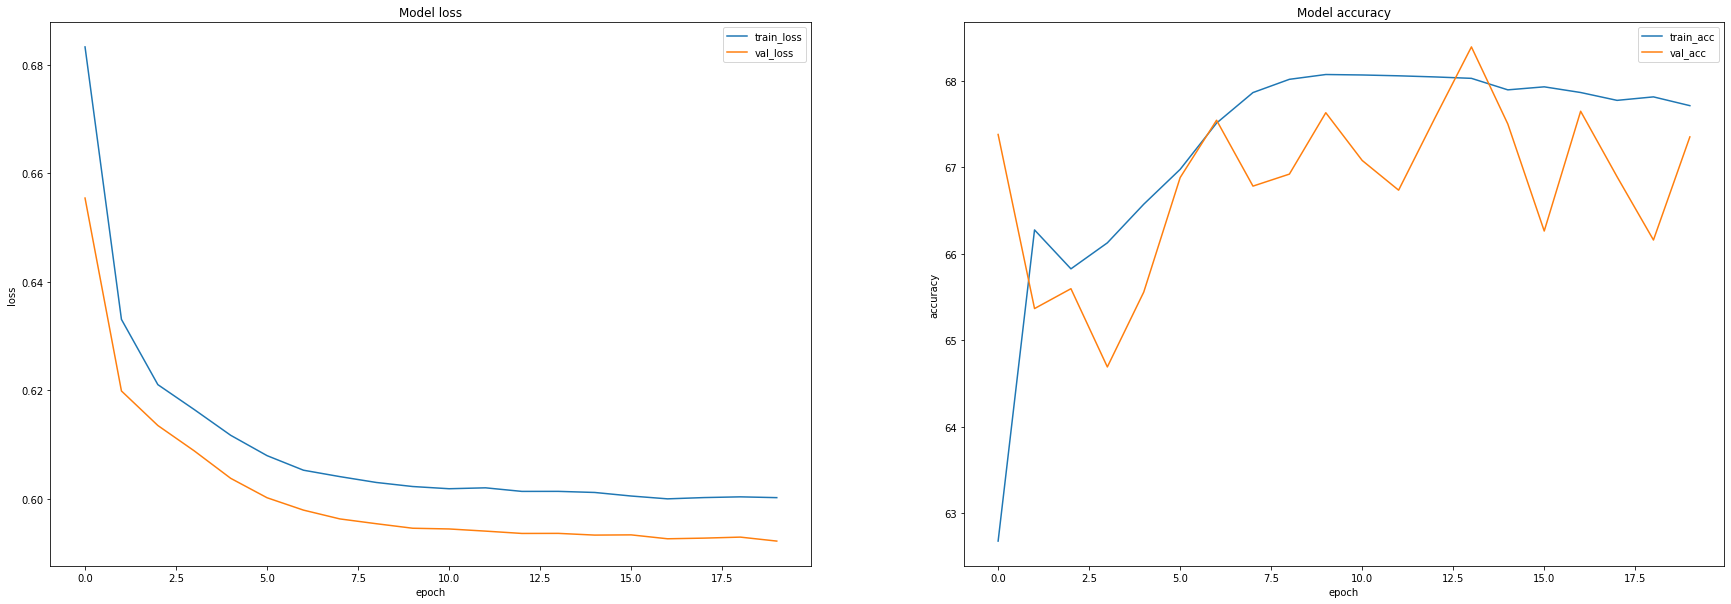

Test Accuracy : 67.60%
Test Loss: 0.5908


In [40]:
y = df_sin.resdefin
class_weight = torch.FloatTensor(compute_class_weight('balanced',classes=np.unique(y),y=y.to_numpy()))

model_diagnosis, X_train, X_test, X_val, Y_train, Y_test, Y_val = pipeline(df_sin.sample(500_000, random_state=42), "resdefin", lr = 0.00001, EPOCHS=20, class_weight=class_weight)

In [41]:
_, predicted = torch.max(model_diagnosis(torch.tensor(X_test)[:,None, :].to(device).float()), 1)

In [42]:
print( classification_report(Y_test, predicted.cpu().numpy(), labels = [0,1], target_names=["NEGATIVE","COVID"]) )

              precision    recall  f1-score   support

    NEGATIVE       0.90      0.66      0.76     78398
       COVID       0.37      0.73      0.49     21602

    accuracy                           0.68    100000
   macro avg       0.63      0.69      0.63    100000
weighted avg       0.78      0.68      0.70    100000



In [43]:
np.savetxt("X_train_diagnosis.csv", X_train, fmt='%s', delimiter=",")
np.savetxt("X_test_diagnosis.csv", X_test, fmt='%s', delimiter=",")
np.savetxt("X_val_diagnosis.csv", X_val, fmt='%s', delimiter=",")
np.savetxt("Y_train_diagnosis.csv", Y_train, fmt='%s', delimiter=",")
np.savetxt("Y_test_diagnosis.csv", Y_test, fmt='%s', delimiter=",")
np.savetxt("Y_val_diagnosis.csv", Y_val, fmt='%s', delimiter=",")

In [44]:
torch.save(model_diagnosis, "model_diagnosis.pth")

In [45]:
m_diagnosis = torch.load("model_diagnosis.pth")

## Hospitalization

In [46]:
not_hosp = df_hosp[df_hosp.tipacien == 0]
hosp = df_hosp[df_hosp.tipacien == 1]
print(f"Original data is disbalanced, hospitalized are only {hosp.shape[0]} while not hospitalized are {not_hosp.shape[0]}")

Original data is disbalanced, hospitalized are only 21836 while not hospitalized are 409276


Longitud X: 431112
Longitud Y: 431112
X_train.shape, Y_train.shape: (258667, 32), (258667,)
X_test.shape, Y_test.shape: (86222, 32), (86222,)
X_val.shape, Y_val.shape: (86222, 32), (86222,)
EPOCHS: 20
Epoch:1/20	Train Loss:0.6523 Validation Loss:0.6063	Train Accuracy:76.69% Validation Accuracy:74.96%
Epoch:2/20	Train Loss:0.5609 Validation Loss:0.5041	Train Accuracy:79.98% Validation Accuracy:80.57%
Epoch:3/20	Train Loss:0.4905 Validation Loss:0.4533	Train Accuracy:82.82% Validation Accuracy:82.54%
Epoch:4/20	Train Loss:0.4584 Validation Loss:0.4248	Train Accuracy:83.85% Validation Accuracy:84.10%
Epoch:5/20	Train Loss:0.4336 Validation Loss:0.3994	Train Accuracy:85.67% Validation Accuracy:84.98%
Epoch:6/20	Train Loss:0.4134 Validation Loss:0.3758	Train Accuracy:87.22% Validation Accuracy:87.27%
Epoch:7/20	Train Loss:0.3905 Validation Loss:0.3571	Train Accuracy:88.51% Validation Accuracy:88.28%
Epoch:8/20	Train Loss:0.3754 Validation Loss:0.3439	Train Accuracy:89.27% Validation Accurac

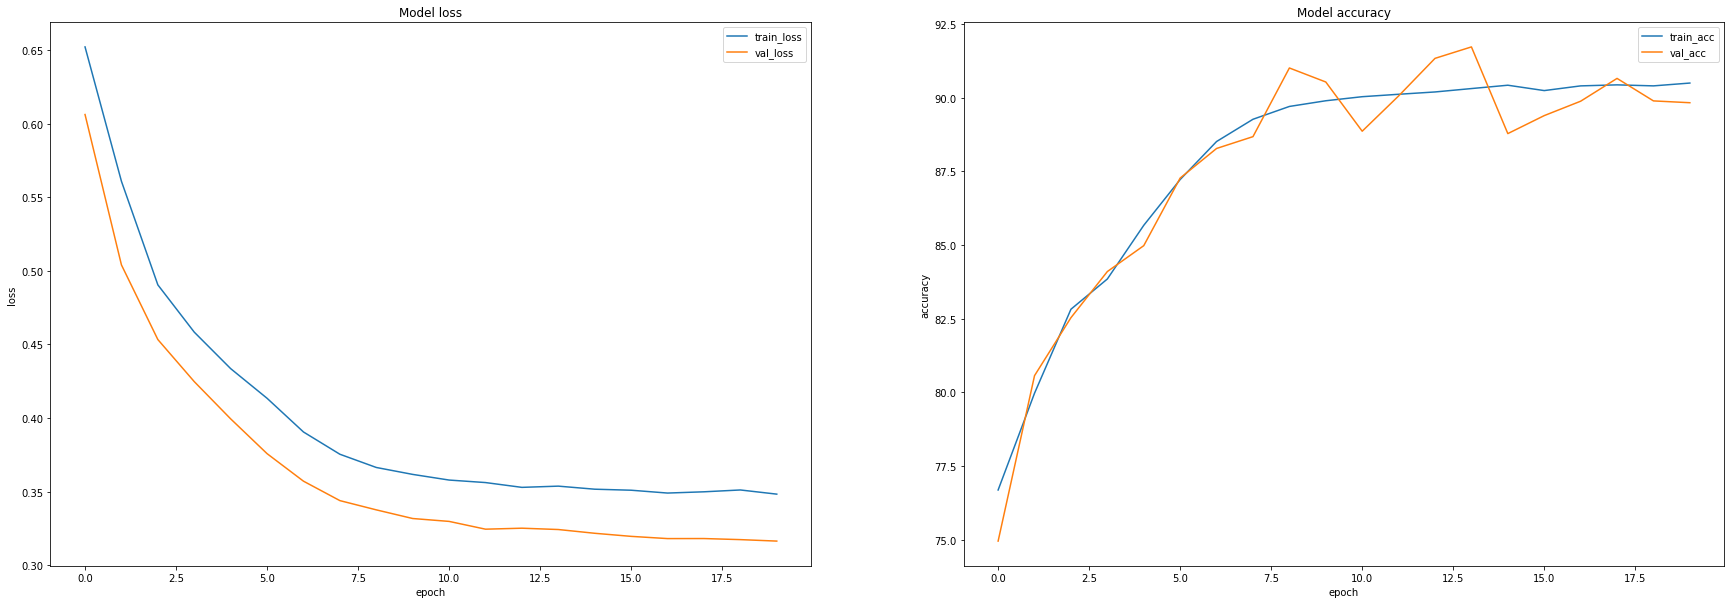

Test Accuracy : 89.91%
Test Loss: 0.3239


In [47]:
y = df_hosp.tipacien
class_weight = torch.FloatTensor(compute_class_weight('balanced',classes=np.unique(y),y=y.to_numpy()))

model_hosp, X_train, X_test, X_val, Y_train, Y_test, Y_val = pipeline(df_hosp, "tipacien", lr = 0.00001, EPOCHS=20, class_weight=class_weight)

In [48]:
_, predicted = torch.max(model_hosp(torch.tensor(X_val)[:,None, :].to(device).float()), 1)

In [49]:
print( classification_report(Y_val, predicted.cpu().numpy(), labels = [0,1], target_names=["NOT HOSPITALIZED","HOSPITALIZED"]) )

                  precision    recall  f1-score   support

NOT HOSPITALIZED       0.99      0.90      0.94     81856
    HOSPITALIZED       0.31      0.84      0.46      4367

        accuracy                           0.90     86223
       macro avg       0.65      0.87      0.70     86223
    weighted avg       0.96      0.90      0.92     86223



In [50]:
np.savetxt("X_train_hosp.csv", X_train, fmt='%s', delimiter=",")
np.savetxt("X_test_hosp.csv", X_test, fmt='%s', delimiter=",")
np.savetxt("X_val_hosp.csv", X_val, fmt='%s', delimiter=",")
np.savetxt("Y_train_hosp.csv", Y_train, fmt='%s', delimiter=",")
np.savetxt("Y_test_hosp.csv", Y_test, fmt='%s', delimiter=",")
np.savetxt("Y_val_hosp.csv", Y_val, fmt='%s', delimiter=",")

In [51]:
torch.save(model_hosp, "model_hosp.pth")

## Defunctions

In [52]:
# Balancing
not_death = df_com[df_com.fecdef == 0]
death = df_com[df_com.fecdef == 1]
#death_bootstraped = death.sample(not_death.shape[0], replace=True)
#df_death_bootstraped = pd.concat([not_death, death_bootstraped], axis=0).sample(frac=1)
print(f"Original data is disbalanced, deads are only {death.shape[0]} while not deads are {not_death.shape[0]}")
#print(f"Before balancing the dataset contained {df_com.shape[0]}, after balancing the dataset contains {df_death_bootstraped.shape[0]}")

Original data is disbalanced, deads are only 9640 while not deads are 421472


Longitud X: 431112
Longitud Y: 431112
X_train.shape, Y_train.shape: (258667, 13), (258667,)
X_test.shape, Y_test.shape: (86222, 13), (86222,)
X_val.shape, Y_val.shape: (86222, 13), (86222,)
EPOCHS: 20
Epoch:1/20	Train Loss:0.6410 Validation Loss:0.5997	Train Accuracy:94.66% Validation Accuracy:92.70%
Epoch:2/20	Train Loss:0.5638 Validation Loss:0.5244	Train Accuracy:85.60% Validation Accuracy:82.73%
Epoch:3/20	Train Loss:0.5024 Validation Loss:0.4738	Train Accuracy:81.80% Validation Accuracy:79.91%
Epoch:4/20	Train Loss:0.4719 Validation Loss:0.4476	Train Accuracy:81.18% Validation Accuracy:80.32%
Epoch:5/20	Train Loss:0.4569 Validation Loss:0.4360	Train Accuracy:81.47% Validation Accuracy:79.82%
Epoch:6/20	Train Loss:0.4541 Validation Loss:0.4323	Train Accuracy:81.74% Validation Accuracy:79.28%
Epoch:7/20	Train Loss:0.4491 Validation Loss:0.4315	Train Accuracy:81.92% Validation Accuracy:82.52%
Epoch:8/20	Train Loss:0.4465 Validation Loss:0.4283	Train Accuracy:82.25% Validation Accurac

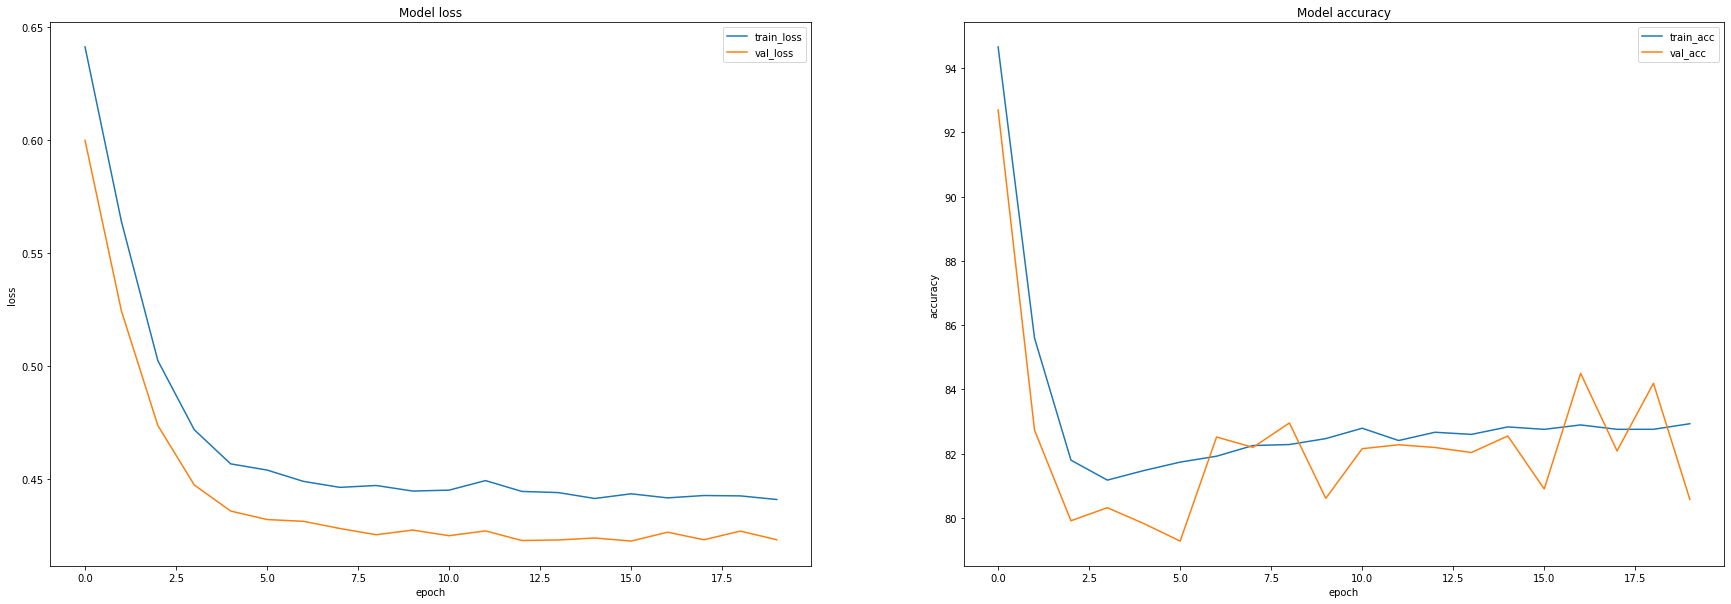

Test Accuracy : 80.56%
Test Loss: 0.4172


In [53]:
y = df_com.fecdef
class_weight = torch.FloatTensor(compute_class_weight('balanced',classes=np.unique(y),y=y.to_numpy()))

model_death, X_train, X_test, X_val, Y_train, Y_test, Y_val = pipeline(df_com, "fecdef", lr = 0.00001, EPOCHS=20, class_weight=class_weight)

In [54]:
_, predicted = torch.max(model_death(torch.tensor(X_val)[:,None, :].to(device).float()), 1)

In [55]:
print( classification_report(Y_val, predicted.cpu().numpy(), labels = [0,1], target_names=["Life","Dead"]) )

              precision    recall  f1-score   support

        Life       0.99      0.81      0.89     84295
        Dead       0.09      0.81      0.16      1928

    accuracy                           0.81     86223
   macro avg       0.54      0.81      0.52     86223
weighted avg       0.97      0.81      0.87     86223



In [56]:
np.savetxt("X_train_death.csv", X_train, fmt='%s', delimiter=",")
np.savetxt("X_test_death.csv", X_test, fmt='%s', delimiter=",")
np.savetxt("X_val_death.csv", X_val, fmt='%s', delimiter=",")
np.savetxt("Y_train_death.csv", Y_train, fmt='%s', delimiter=",")
np.savetxt("Y_test_death.csv", Y_test, fmt='%s', delimiter=",")
np.savetxt("Y_val_death.csv", Y_val, fmt='%s', delimiter=",")

In [57]:
torch.save(model_death, "model_death.pth")

# Use cases

## Covid Diagnosis

In [58]:
sexo = 1
edad = 70
fiebre = 1
tos = 1
odinogia = 1
disnea = 1
irritabi = 1
diarrea = 1
dotoraci = 1
calofrios = 1
cefalea = 1
mialgias = 1
artral = 1
ataedoge = 1
rinorrea = 1
polipnea = 1
vomito = 1
dolabdo = 1
conjun = 1
cianosis = 1
inisubis = 1

X = np.array([[sexo, edad, fiebre, tos, odinogia, disnea, irritabi,
  diarrea, dotoraci, calofrios, cefalea, mialgias, artral,
  ataedoge, rinorrea, polipnea, vomito, dolabdo, conjun,
  cianosis, inisubis]])

res = predict_model_diagnosis(model, X, 'cuda') 


probs = prob_model_diagnosis(model, X, 'cuda') 

if res == 1:
    print(f"El clasificador indica que eres POSITIVO a COVID-19 con probabilidad de {probs[1]:.2f}%")
elif res == 0:
    print(f"El clasificador indica que eres NEGATIVO a COVID-19 con probabilidad de {probs[0]:.2f}%")

NameError: name 'model' is not defined